In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Constants for data generation
m_values = [0.5, 0.2, 0.4, 0.6, 10, 0.01, 0.3, 0.02]
num_samples = 5000

# Generate data
Income = np.random.uniform(1000, 10000, num_samples)
Age = np.random.uniform(18, 80, num_samples)
PSQ = np.random.uniform(0, 100, num_samples)
SES = np.random.uniform(0, 100, num_samples)

HS = (m_values[0] * Income + m_values[1] * Age + m_values[2] * PSQ + m_values[3] * SES 
      + m_values[4] * np.sin(m_values[5] * Age * SES)
      + m_values[6] * np.log(m_values[7] * Income * PSQ + 1) 
      + np.random.normal(0, 10, num_samples))

# Convert to PyTorch tensors
X = torch.tensor(np.vstack([Income, Age, PSQ, SES]).T, dtype=torch.float32)
y = torch.tensor(HS, dtype=torch.float32).view(-1, 1)

# Generate test data
Income = np.random.uniform(1000, 10000, num_samples)
Age = np.random.uniform(18, 80, num_samples)
PSQ = np.random.uniform(0, 100, num_samples)
SES = np.random.uniform(0, 100, num_samples)

HS = (m_values[0] * Income + m_values[1] * Age + m_values[2] * PSQ + m_values[3] * SES 
      + m_values[4] * np.sin(m_values[5] * Age * SES)
      + m_values[6] * np.log(m_values[7] * Income * PSQ + 1) 
      + np.random.normal(0, 10, num_samples))

# Convert to PyTorch tensors
X_test = torch.tensor(np.vstack([Income, Age, PSQ, SES]).T, dtype=torch.float32)
y_test = torch.tensor(HS, dtype=torch.float32).view(-1, 1)



In [3]:
# Neural Network Model
class HappinessPredictor(nn.Module):
    def __init__(self):
        super(HappinessPredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [4]:
## Case 1: Only learning based on one loss
result=[]
for i in range(10):
    model = HappinessPredictor()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training Loop with Multi-Loss
    epochs = 500
    for epoch in range(epochs):
        # Forward pass
        outputs = model(X)

        # Main Loss
        loss_main = criterion(outputs, y)

        # Interaction Loss
        sin_interaction = m_values[4] * torch.sin(m_values[5] * X[:, 1].view(-1, 1) * X[:, 3].view(-1, 1))
        log_interaction = m_values[6] * torch.log(m_values[7] * X[:, 0].view(-1, 1) * X[:, 2].view(-1, 1) + 1)
        interaction_predicted = outputs - (m_values[0] * X[:, 0].view(-1, 1) + m_values[1] * X[:, 1].view(-1, 1) + m_values[2] * X[:, 2].view(-1, 1) + m_values[3] * X[:, 3].view(-1, 1))
        loss_interaction = criterion(interaction_predicted, sin_interaction + log_interaction)

        # Combined Loss
        combined_loss = loss_main + 0 * loss_interaction

        # Backprop and optimization
        optimizer.zero_grad()
        combined_loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {combined_loss.item():.4f}")

    print("Training Finished!")

    result.append(mean_squared_error(model(X_test).detach().numpy(),y_test,squared=False))

Epoch [50/500], Loss: 38595.7969
Epoch [100/500], Loss: 856.1059
Epoch [150/500], Loss: 563.8263
Epoch [200/500], Loss: 343.3604
Epoch [250/500], Loss: 230.2284
Epoch [300/500], Loss: 191.8029
Epoch [350/500], Loss: 179.2176
Epoch [400/500], Loss: 172.1750
Epoch [450/500], Loss: 166.7632
Epoch [500/500], Loss: 162.4427
Training Finished!
Epoch [50/500], Loss: 1795.8334
Epoch [100/500], Loss: 1554.2325
Epoch [150/500], Loss: 1461.1840
Epoch [200/500], Loss: 1409.5706
Epoch [250/500], Loss: 1352.2881
Epoch [300/500], Loss: 1289.2720
Epoch [350/500], Loss: 1217.7551
Epoch [400/500], Loss: 1124.3630
Epoch [450/500], Loss: 1028.7816
Epoch [500/500], Loss: 924.3867
Training Finished!
Epoch [50/500], Loss: 1486.4857
Epoch [100/500], Loss: 1386.6136
Epoch [150/500], Loss: 1174.4631
Epoch [200/500], Loss: 1002.1030
Epoch [250/500], Loss: 798.3884
Epoch [300/500], Loss: 594.2061
Epoch [350/500], Loss: 425.1112
Epoch [400/500], Loss: 310.6812
Epoch [450/500], Loss: 246.5733
Epoch [500/500], Loss:

16.455282
6.4212837
13.059326


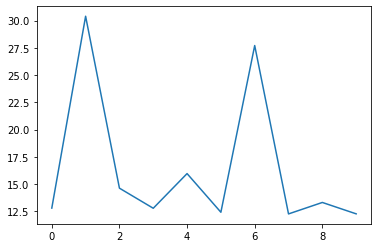

In [5]:
## Mean, median , variation of RMSE of predicted and given target
print(np.mean(result))
print(np.std(result))
print(np.median(result))
plt.plot(result)

In [6]:
## Case 2: Learning based on both losses but equal weights
result=[]
for i in range(10):
    model = HappinessPredictor()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training Loop with Multi-Loss
    epochs = 500
    for epoch in range(epochs):
        # Forward pass
        outputs = model(X)

        # Main Loss
        loss_main = criterion(outputs, y)

        # Interaction Loss
        sin_interaction = m_values[4] * torch.sin(m_values[5] * X[:, 1].view(-1, 1) * X[:, 3].view(-1, 1))
        log_interaction = m_values[6] * torch.log(m_values[7] * X[:, 0].view(-1, 1) * X[:, 2].view(-1, 1) + 1)
        interaction_predicted = outputs - (m_values[0] * X[:, 0].view(-1, 1) + m_values[1] * X[:, 1].view(-1, 1) + m_values[2] * X[:, 2].view(-1, 1) + m_values[3] * X[:, 3].view(-1, 1))
        loss_interaction = criterion(interaction_predicted, sin_interaction + log_interaction)

        # Combined Loss
        combined_loss = 0.5*loss_main + 0.5*loss_interaction

        # Backprop and optimization
        optimizer.zero_grad()
        combined_loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {combined_loss.item():.4f}")

    print("Training Finished!")
    result.append(mean_squared_error(model(X_test).detach().numpy(),y_test,squared=False))

Epoch [50/500], Loss: 11465.3926
Epoch [100/500], Loss: 1225.1923
Epoch [150/500], Loss: 1168.6589
Epoch [200/500], Loss: 1134.9281
Epoch [250/500], Loss: 1098.6367
Epoch [300/500], Loss: 1059.5480
Epoch [350/500], Loss: 1018.3127
Epoch [400/500], Loss: 975.4971
Epoch [450/500], Loss: 931.5880
Epoch [500/500], Loss: 887.0293
Training Finished!
Epoch [50/500], Loss: 5922.4102
Epoch [100/500], Loss: 947.3677
Epoch [150/500], Loss: 919.8239
Epoch [200/500], Loss: 890.5388
Epoch [250/500], Loss: 859.0625
Epoch [300/500], Loss: 825.2206
Epoch [350/500], Loss: 789.5945
Epoch [400/500], Loss: 752.6826
Epoch [450/500], Loss: 714.9182
Epoch [500/500], Loss: 676.7432
Training Finished!
Epoch [50/500], Loss: 4503.1021
Epoch [100/500], Loss: 1390.7148
Epoch [150/500], Loss: 1084.5626
Epoch [200/500], Loss: 649.1609
Epoch [250/500], Loss: 272.4798
Epoch [300/500], Loss: 129.9332
Epoch [350/500], Loss: 107.5759
Epoch [400/500], Loss: 103.6350
Epoch [450/500], Loss: 101.4779
Epoch [500/500], Loss: 10

16.592922
6.3633037
13.018545


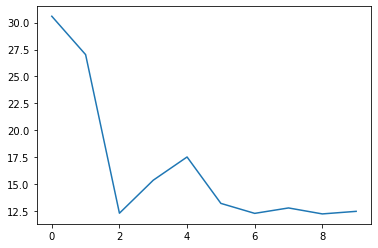

In [7]:
## Mean, median , variation of RMSE of predicted and given target
print(np.mean(result))
print(np.std(result))
print(np.median(result))
plt.plot(result)

In [8]:
## Case 3: Learning based on both loss based on dynamically learned contribution of each losses at each iteration based
## on entire loss history
result=[]
for i in range(10):
    model = HappinessPredictor()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training Loop with Multi-Loss
    epochs = 500
    loss_history=[]
    loss_main_history=[]
    loss_main_ratio_history=[]
    loss_seasonality_history=[]
    loss_seasonality_ratio_history=[]
    w1_history=[]
    w2_history=[]
    for epoch in range(epochs):
        # Forward pass
        outputs = model(X)

        # Main Loss
        loss_main = criterion(outputs, y)

        # Interaction Loss
        sin_interaction = m_values[4] * torch.sin(m_values[5] * X[:, 1].view(-1, 1) * X[:, 3].view(-1, 1))
        log_interaction = m_values[6] * torch.log(m_values[7] * X[:, 0].view(-1, 1) * X[:, 2].view(-1, 1) + 1)
        interaction_predicted = outputs - (m_values[0] * X[:, 0].view(-1, 1) + m_values[1] * X[:, 1].view(-1, 1) + m_values[2] * X[:, 2].view(-1, 1) + m_values[3] * X[:, 3].view(-1, 1))
        loss_seasonality = criterion(interaction_predicted, sin_interaction + log_interaction)

        # Combined loss
        w1=0.5
        w2=0.5
        if(epoch>=2):
            loss_main_mu_minus1=np.mean(loss_main_history[:-1])
            loss_seasonality_mu_minus1=np.mean(loss_seasonality_history[:-1])
            loss_main_ratio=loss_main.detach().numpy()/loss_main_mu_minus1
            loss_seasonality_ratio=loss_seasonality.detach().numpy()/loss_seasonality_mu_minus1
            loss_main_ratio_history.append(loss_main_ratio)
            loss_seasonality_ratio_history.append(loss_seasonality_ratio)

        if(epoch>=10):    
            w1=np.std(loss_main_ratio_history)/np.mean(loss_main_ratio_history)
            w2=np.std(loss_seasonality_ratio_history)/np.mean(loss_seasonality_ratio_history)
            wtotal=w1+w2
            w1=w1/wtotal
            w2=w2/wtotal

        loss = w1*loss_main + w2 * loss_seasonality
        loss_history.append(loss.detach().numpy())
        loss_main_history.append(loss_main.detach().numpy())
        loss_seasonality_history.append(loss_seasonality.detach().numpy())
        w1_history.append(w1)
        w2_history.append(w2)
        # Backprop and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

    print("Training Finished!")
    result.append(mean_squared_error(model(X_test).detach().numpy(),y_test,squared=False))

Epoch [50/500], Loss: 12998.0225
Epoch [100/500], Loss: 770.1791
Epoch [150/500], Loss: 436.9546
Epoch [200/500], Loss: 206.6562
Epoch [250/500], Loss: 118.1296
Epoch [300/500], Loss: 101.3248
Epoch [350/500], Loss: 99.4893
Epoch [400/500], Loss: 99.0187
Epoch [450/500], Loss: 98.6247
Epoch [500/500], Loss: 98.2414
Training Finished!
Epoch [50/500], Loss: 35349.5156
Epoch [100/500], Loss: 926.7355
Epoch [150/500], Loss: 586.2114
Epoch [200/500], Loss: 391.3362
Epoch [250/500], Loss: 247.2327
Epoch [300/500], Loss: 170.3096
Epoch [350/500], Loss: 139.4948
Epoch [400/500], Loss: 127.0275
Epoch [450/500], Loss: 119.5944
Epoch [500/500], Loss: 113.9053
Training Finished!
Epoch [50/500], Loss: 12403.0430
Epoch [100/500], Loss: 816.3417
Epoch [150/500], Loss: 506.5687
Epoch [200/500], Loss: 250.9948
Epoch [250/500], Loss: 132.0910
Epoch [300/500], Loss: 103.7998
Epoch [350/500], Loss: 100.3577
Epoch [400/500], Loss: 99.7121
Epoch [450/500], Loss: 99.2656
Epoch [500/500], Loss: 98.8834
Traini

14.823702
4.66793
12.786421


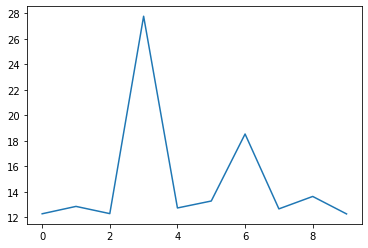

In [9]:
## Mean, median , variation of RMSE of predicted and given target
print(np.mean(result))
print(np.std(result))
print(np.median(result))
plt.plot(result)

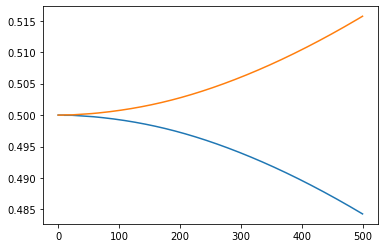

In [12]:
plt.plot(w1_history)
plt.plot(w2_history)

In [26]:
## Case 4: Learning based on both loss based on dynamically learned contribution of each losses at each iteration based
## on last 10 losses history
result=[]
for i in range(10):
    model = HappinessPredictor()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training Loop with Multi-Loss
    epochs = 500
    loss_history=[]
    loss_main_history=[]
    loss_main_ratio_history=[]
    loss_seasonality_history=[]
    loss_seasonality_ratio_history=[]
    w1_history=[]
    w2_history=[]
    for epoch in range(epochs):
        # Forward pass
        outputs = model(X)

        # Main Loss
        loss_main = criterion(outputs, y)

        # Interaction Loss
        sin_interaction = m_values[4] * torch.sin(m_values[5] * X[:, 1].view(-1, 1) * X[:, 3].view(-1, 1))
        log_interaction = m_values[6] * torch.log(m_values[7] * X[:, 0].view(-1, 1) * X[:, 2].view(-1, 1) + 1)
        interaction_predicted = outputs - (m_values[0] * X[:, 0].view(-1, 1) + m_values[1] * X[:, 1].view(-1, 1) + m_values[2] * X[:, 2].view(-1, 1) + m_values[3] * X[:, 3].view(-1, 1))
        loss_seasonality = criterion(interaction_predicted, sin_interaction + log_interaction)

        # Combined loss
        w1=0.5
        w2=0.5
        if(epoch>=2):
            loss_main_mu_minus1=np.mean(loss_main_history[:-1])
            loss_seasonality_mu_minus1=np.mean(loss_seasonality_history[:-1])
            loss_main_ratio=loss_main.detach().numpy()/loss_main_mu_minus1
            loss_seasonality_ratio=loss_seasonality.detach().numpy()/loss_seasonality_mu_minus1
            loss_main_ratio_history.append(loss_main_ratio)
            loss_seasonality_ratio_history.append(loss_seasonality_ratio)

        if(epoch>=10):    
            w1=np.std(loss_main_ratio_history[-10:])/np.mean(loss_main_ratio_history[-10:])
            w2=np.std(loss_seasonality_ratio_history[-10:])/np.mean(loss_seasonality_ratio_history[-10:])
            wtotal=w1+w2
            w1=w1/wtotal
            w2=w2/wtotal

        loss = w1*loss_main + w2 * loss_seasonality
        loss_history.append(loss.detach().numpy())
        loss_main_history.append(loss_main.detach().numpy())
        loss_seasonality_history.append(loss_seasonality.detach().numpy())
        w1_history.append(w1)
        w2_history.append(w2)
        # Backprop and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

    print("Training Finished!")
    result.append(mean_squared_error(model(X_test).detach().numpy(),y_test,squared=False))

Epoch [50/500], Loss: 1184.4194
Epoch [100/500], Loss: 717.7467
Epoch [150/500], Loss: 422.0475
Epoch [200/500], Loss: 254.4365
Epoch [250/500], Loss: 149.9167
Epoch [300/500], Loss: 156.3810
Epoch [350/500], Loss: 165.6259
Epoch [400/500], Loss: 154.4342
Epoch [450/500], Loss: 99.7406
Epoch [500/500], Loss: 137.7900
Training Finished!
Epoch [50/500], Loss: 22535.1504
Epoch [100/500], Loss: 1048.5449
Epoch [150/500], Loss: 700.6117
Epoch [200/500], Loss: 444.7389
Epoch [250/500], Loss: 264.0236
Epoch [300/500], Loss: 162.3609
Epoch [350/500], Loss: 129.7306
Epoch [400/500], Loss: 183.7839
Epoch [450/500], Loss: 157.3798
Epoch [500/500], Loss: 148.4822
Training Finished!
Epoch [50/500], Loss: 16982.1367
Epoch [100/500], Loss: 808.2175
Epoch [150/500], Loss: 511.2730
Epoch [200/500], Loss: 313.7901
Epoch [250/500], Loss: 190.5787
Epoch [300/500], Loss: 225.1671
Epoch [350/500], Loss: 208.2463
Epoch [400/500], Loss: 177.9017
Epoch [450/500], Loss: 156.8379
Epoch [500/500], Loss: 145.1704


13.280696
1.0813326
12.865767


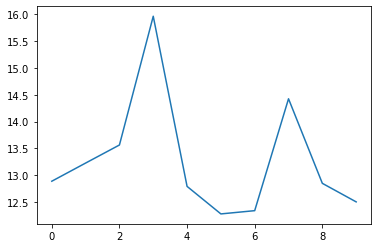

In [30]:
## Mean, median , variation of RMSE of predicted and given target
print(np.mean(result))
print(np.std(result))
print(np.median(result))
plt.plot(result)

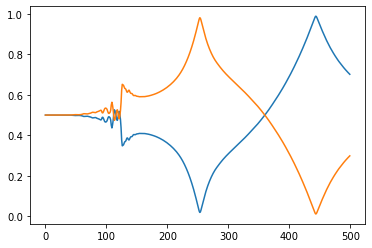

In [31]:
plt.plot(w1_history)
plt.plot(w2_history)

In [10]:
## Exact effectiveness (might not be very evident) of training with multiple losses here for an artificial data (as I can't 
## share the exact data i worked on, but implementation here is based on the research
## paper idea mentioned below. This type of loss function calculation is supposed to be done for single task multi loss problem.

## We can still observed the overall reduction in error with this approach of dynamic weight adjustment. Error further reduced
## if coeficient of variation of losses are calculated just over past 10 values instead of all 10 values.

## I have used the similar approach for a 3d reconstruction bundle adjustment problem where I had two losses i) conventional 
## reconstruction loss ii) structural similarity loss. so two loss of different and one task now.

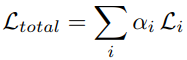

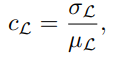

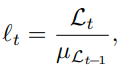

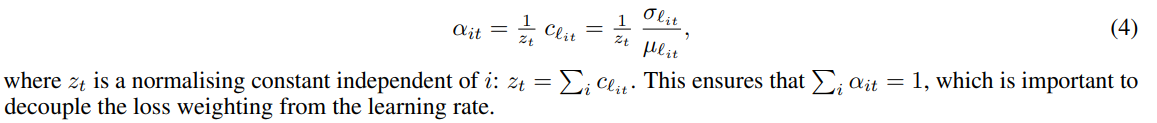